In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/submission/Submission_template_UHI2025-v2.csv
/kaggle/input/uncorrupted-training-data/Training_data_uhi_index_2025-02-18.csv


In [2]:
pip install overpy

Note: you may need to restart the kernel to use updated packages.


In [3]:
import overpy
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

Number of ways fetched: 2484


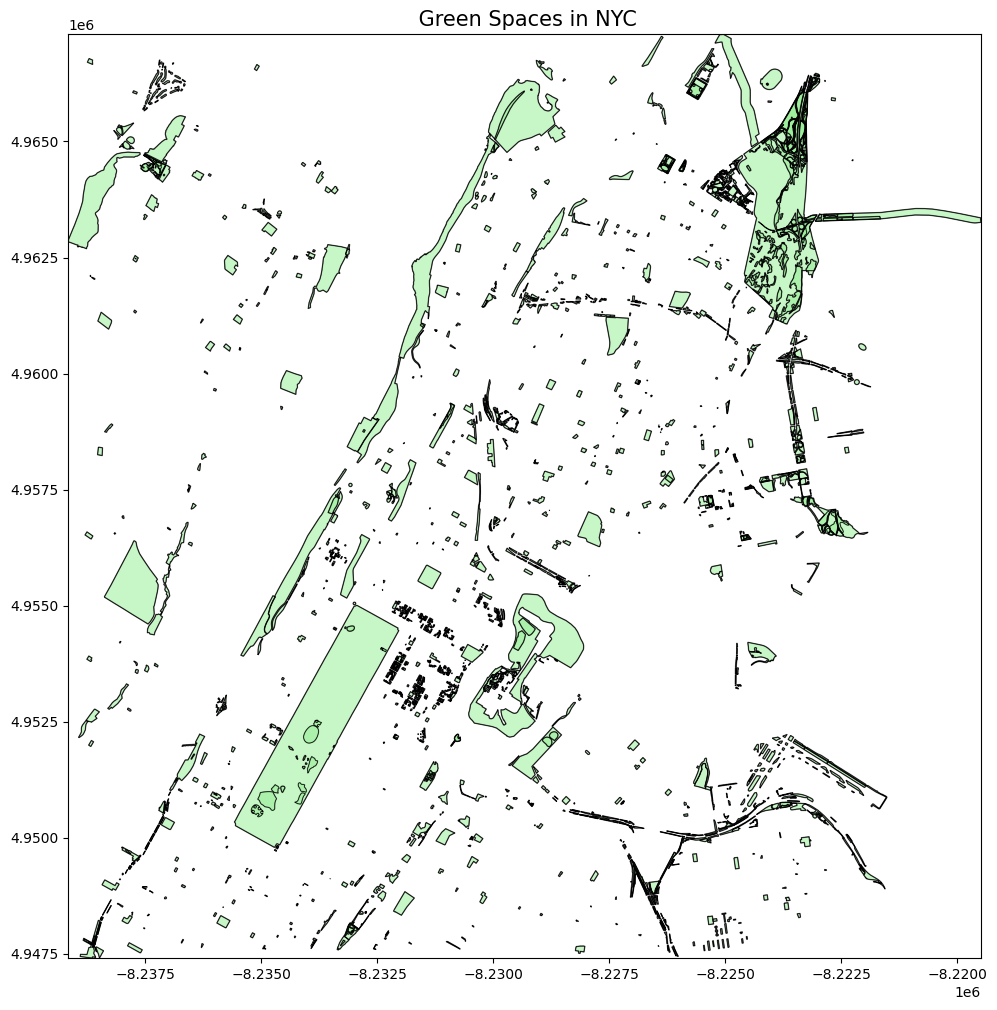

Successfully plotted 2484 green spaces with 150m buffer


In [4]:
# Set up the Overpass API client
api = overpy.Overpass()

# Define the bounding box (Lat, Lon)
lower_left = (40.75, -74.01)
upper_right = (40.88, -73.86)

# Create the Overpass query for parks and green spaces
overpass_query = f"""
[out:json];
(
  way["leisure"="park"]({lower_left[0]},{lower_left[1]},{upper_right[0]},{upper_right[1]});
  way["landuse"~"forest|grass"]({lower_left[0]},{lower_left[1]},{upper_right[0]},{upper_right[1]});
);
out body;
(._;>;);
out skel qt;
"""

try:
    # Fetch the data from Overpass API
    result = api.query(overpass_query)
    print(f"Number of ways fetched: {len(result.ways)}")
    
    # Parse the data into GeoDataFrame
    geometries = []
    names = []
    
    for way in result.ways:
        try:
            nodes = [(float(node.lon), float(node.lat)) for node in way.nodes]  # Note: switched lon/lat order
            if len(nodes) > 2:
                polygon = Polygon(nodes)
                geometries.append(polygon)
                names.append(way.tags.get('name', 'Unnamed'))
        except Exception as e:
            print(f"Error processing way {way.id}: {str(e)}")
    
    # Create a GeoDataFrame if geometries exist
    if geometries:
        gdf = gpd.GeoDataFrame({
            'name': names,
            'geometry': geometries
        }, crs="EPSG:4326")  # Specify the coordinate reference system
        
        # Reproject to a CRS with meters as units (EPSG:3395)
        gdf = gdf.to_crs(epsg=3395)
        
        # Create the plot
        fig, ax = plt.subplots(figsize=(12, 12))
        
        # Plot the buffered regions
        gdf.plot(ax=ax, color="lightgreen", alpha=0.5, edgecolor="black")
        
        # Add map context (optional)
        gdf.boundary.plot(ax=ax, color="black", linewidth=0.5)
        
        # Set plot limits to match bounding box
        ax.set_xlim(gdf.total_bounds[0], gdf.total_bounds[2])  # xmin, xmax
        ax.set_ylim(gdf.total_bounds[1], gdf.total_bounds[3])  # ymin, ymax
        
        ax.set_title(" Green Spaces in NYC", fontsize=15)
        ax.axis('on')  # Show axes to verify coordinates
        plt.show()
        
        print(f"Successfully plotted {len(gdf)} green spaces with 150m buffer")
    else:
        print("No valid geometries found to plot")

except overpy.exception.OverpassTooManyRequests:
    print("Too many requests to Overpass API. Please wait and try again.")
except Exception as e:
    print(f"An error occurred: {str(e)}")


In [5]:
train_df = pd.read_csv("/kaggle/input/uncorrupted-training-data/Training_data_uhi_index_2025-02-18.csv")

In [6]:
from shapely.geometry import Point

# Convert train_df into a GeoDataFrame
gdf_train = gpd.GeoDataFrame(train_df, 
                             geometry=[Point(lon, lat) for lon, lat in zip(train_df['Longitude'], train_df['Latitude'])], 
                             crs="EPSG:4326")

# Convert green space data to a GeoDataFrame 
gdf_green = gdf  # Ensure this contains the green space geometries

# Reproject to EPSG:3395 for accurate distance-based operations
gdf_train = gdf_train.to_crs(epsg=3395)
gdf_green = gdf_green.to_crs(epsg=3395)

# Create a 200m buffer around each train point
gdf_train['buffer'] = gdf_train.geometry.buffer(550)

# Compute intersection area with green spaces
def compute_green_space_area(buffer_geom):
    intersection = gdf_green.geometry.intersection(buffer_geom)
    return intersection.area.sum()  # Sum up the area of all intersections

# Apply the function to compute green space area around each point
gdf_train['green_space'] = gdf_train['buffer'].apply(compute_green_space_area)

# Convert back to a regular DataFrame if needed
train_df['green_space'] = gdf_train['green_space']

# Check results
print(train_df[['Latitude', 'Longitude', 'green_space']].head())

    Latitude  Longitude    green_space
0  40.813107 -73.909167  185571.898005
1  40.813045 -73.909187  189946.352368
2  40.812978 -73.909215  194989.481631
3  40.812908 -73.909242  200157.261231
4  40.812845 -73.909257  204423.999904


In [7]:
train_df

,Longitude,Latitude,datetime,UHI Index,green_space
0,-73.909167,40.813107,24-07-2021 15:53,1.030289,185571.898005
1,-73.909187,40.813045,24-07-2021 15:53,1.030289,189946.352368
2,-73.909215,40.812978,24-07-2021 15:53,1.023798,194989.481631
3,-73.909242,40.812908,24-07-2021 15:53,1.023798,200157.261231
4,-73.909257,40.812845,24-07-2021 15:53,1.021634,204423.999904
...,...,...,...,...,...
11224,-73.957050,40.790333,24-07-2021 15:57,0.972470,766445.994788
11225,-73.957063,40.790308,24-07-2021 15:57,0.972470,765978.971688
11226,-73.957093,40.790270,24-07-2021 15:57,0.981124,766132.688085
11227,-73.957112,40.790253,24-07-2021 15:59,0.981245,766681.994497


In [8]:
train_df['green_space'].describe()

count    1.122900e+04
mean     1.063684e+05
std      1.728215e+05
min      0.000000e+00
25%      1.829754e+04
50%      4.686600e+04
75%      1.124579e+05
max      1.104426e+06
Name: green_space, dtype: float64

In [9]:
train_df.to_csv('train_df_with_green_space.csv', index=False)

In [10]:
valid_df = pd.read_csv("/kaggle/input/submission/Submission_template_UHI2025-v2.csv")

In [11]:
# Convert valid_df into a GeoDataFrame
gdf_valid = gpd.GeoDataFrame(valid_df, 
                             geometry=[Point(lon, lat) for lon, lat in zip(valid_df['Longitude'], valid_df['Latitude'])], 
                             crs="EPSG:4326")

# Reproject valid_df and green space GeoDataFrame to EPSG:3395
gdf_valid = gdf_valid.to_crs(epsg=3395)
gdf_green = gdf_green.to_crs(epsg=3395)  # Already reprojected in previous steps

# Create a 200m buffer around each validation point
gdf_valid['buffer'] = gdf_valid.geometry.buffer(550)

# Compute intersection area with green spaces
gdf_valid['green_space'] = gdf_valid['buffer'].apply(
    lambda buffer_geom: gdf_green.geometry.intersection(buffer_geom).area.sum()
)

# Convert back to a regular DataFrame if needed
valid_df['green_space'] = gdf_valid['green_space']

# Check results
print(valid_df[['Latitude', 'Longitude', 'green_space']].head())

    Latitude  Longitude    green_space
0  40.788763 -73.971665   24499.889319
1  40.788875 -73.971928   10574.872312
2  40.789080 -73.967080  403763.833896
3  40.789082 -73.972550    5144.297626
4  40.787953 -73.969697  222084.003584


In [12]:
valid_df

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Longitude,Latitude,UHI Index,green_space
0,-73.971665,40.788763,NaN,24499.889319
1,-73.971928,40.788875,NaN,10574.872312
2,-73.967080,40.789080,NaN,403763.833896
3,-73.972550,40.789082,NaN,5144.297626
4,-73.969697,40.787953,NaN,222084.003584
...,...,...,...,...
1035,-73.919388,40.813803,NaN,20663.538164
1036,-73.931033,40.833178,NaN,24577.469506
1037,-73.934647,40.854542,NaN,24798.812147
1038,-73.917223,40.815413,NaN,16013.999576


In [13]:
valid_df['green_space'].describe()

count    1.040000e+03
mean     1.023776e+05
std      1.652814e+05
min      0.000000e+00
25%      1.772408e+04
50%      4.366951e+04
75%      1.116242e+05
max      1.033902e+06
Name: green_space, dtype: float64

In [14]:
valid_df.to_csv('valid_df_with_green_space.csv', index=False)